In [1]:
## Include packages

using DelimitedFiles
using DCAUtils
using Plots
using Statistics
using KitMSA
using FastaIO
using LinearAlgebra
using StatsBase

include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
;

In [2]:
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_denseDBDnc.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)
;

In [3]:
function compare_seq(a::Array{Int8,1}, b::Array{Int8,1})
    if a == b
        return 0
    else
        return findall(a .!= b)[1]
    end
end

function find_positions(msa)
    
    return [compare_seq(msa[j-1,:], msa[j,:]) for j in 2:length(msa[:,1])]
        
end


function mut_effect_WTtoB_one_seq(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq, mut_s, b)
    
    seq_pre = deepcopy(seq)
    seq_post = deepcopy(seq)
    
    seq_post[mut_s] = b
    
    return delta_energy(h,J, seq_post, seq_pre)
    
end


function mut_effect_WTtoA_one_seq(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq, mut_s, a)
    
    seq_pre = deepcopy(seq)
    seq_post = deepcopy(seq)
    
    seq_post[mut_s] = a
    
    return delta_energy(h,J, seq_post, seq_pre)
    
end

   
function cont_entr_over_time(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq_chain::Array{Int8,2}, mut_t, mut_s, a, b, window)
    
    res = Array{Float64}(undef,2*window+1)
    idx = 0
    for i in mut_t-window:mut_t
        idx+=1
        
        if seq_chain[i,:] == seq_chain[i-1,:] 
            #println("no mut")
            if idx !=1
                res[idx] = res[idx-1]
            end
        else        
            res[idx] = mut_effect_WTtoB_one_seq(h, J, seq_chain[i,:], mut_s, b)
        end
    end

    for i in mut_t+1:mut_t+window
        idx+=1
        
        if seq_chain[i,:] == seq_chain[i-1,:] 
            #println("no mut")
            if idx !=1
                res[idx] = res[idx-1]
            end
        else        
            res[idx] = mut_effect_WTtoA_one_seq(h, J, seq_chain[i,:], mut_s, a)
        end
    end

    return res
end

function cont_entr_setofmuts(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq_chain::Array{Int8,2}, mut_times::Array{Int64,1}, 
        mut_sites::Array{Int64,1}, a, b, n_muts, start_t,window)
    res = Array{Float64}(undef, n_muts, 2*window+1)
    for i in 1:n_muts
        res[i,:] = cont_entr_over_time(h, J, 
            seq_chain, mut_times[start_t+i], mut_sites[start_t+i], 
            a[start_t+i], b[start_t+i], window)
    end
    return res
end

function cont_entr_setofmuts_eachstep(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq_chain::Array{Int8,2}, mut_times::Array{Int64,1}, 
        mut_sites::Array{Int64,1}, a, b, window, mut_range)
    res = Array{Float64}(undef, length(mut_range), 2*window+1)
    idx = 0
    for i in mut_range
        idx +=1
        res[idx,:] = cont_entr_over_time(h, J, seq_chain, mut_times[i], mut_sites[i], 
            a[i], b[i], window)
    end
    return res
end

function get_entropy(f; q =21)
    N=length(f[1,:])
    entr = zeros(Float64, N)
    for i in 1:N
        for a in 1:q
            if(f[a,i]>0)
                entr[i]-=f[a,i]*log(f[a,i])
            end
        end
    end
    
    return entr
end

function proba_DNA_gibbs_without_deg(k, mutated_seq, h, J, N; q = 21, T = 1)
	prob = zeros(q)
	for i in 1:q
        q_k = i
		log_proba = h[q_k, k]
 		for j in 1:N
			log_proba += J[mutated_seq[j], q_k , j, k]
        end#
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

function cont_dep_entr_without_deg(background, h, J; q =21, T =1)
    
    N = length(background)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs_without_deg(pos_mut, background, h, J, N, T=T, q=q)) for pos_mut in 1:N]...)

    return get_entropy(prob, q = q)[:]
end

function write_cde_of_chains(folder, out_path, mask, h, J, n)
    fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder))
    res = []
    for i in 1:n
        chain = Int8.(fasta2matrix(joinpath(folder_path, fasta_files[i])))[mask,:]
        cde_msa = hcat([cont_dep_entr_without_deg(chain[step,:], h, J, q= 21) 
                for step in 1:length(chain[:,1])]...)'
        push!(res, vec(cde_msa))
        if i %10 == 0
            println(i)
        end
    end
    writedlm(out_path, hcat(res...))
    return hcat(res...)
end

function cde_1site(site, background, h, J; q = 21,  T = 1)
  
    N = length(background)
    println(N)
    prob = ProbabilityWeights(proba_DNA_gibbs_without_deg(site, 
            background, h, J, N, T = T, q = q))
    return get_entropy(prob, q = q)
end

cde_1site (generic function with 1 method)

In [4]:
path_wt_pse = "../data/alignments/refs/PSE1_pfam_DNA.fasta"

#load wt
wt_pse = join(readdlm(path_wt_pse, skipstart = 1))
L_pse = Int64(length(wt_pse)/3)
pse_DNA_seq = [wt_pse[((i-1)*3 +1):(i*3)] for i in 1:L_pse]
pse_amino_seq = [cod2amino[codon] for codon in pse_DNA_seq]
path_beta = "../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"
nat_beta = Int8.(fasta2matrix(path_beta))
path_nat = "../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"
nat_MSA = Int8.(fasta2matrix(path_nat))
path_dbd = "../data/alignments/natural/DBD_alignment.uniref90.cov80.noclose.a2m"
nat_dbd = Int8.(fasta2matrix(path_dbd))
;

In [5]:
folder_path = "../data/chains/equil_det_bal_dbd_silico_chain_num_1_T_1.0.fasta"

@time matrices = Int8.(fasta2matrix(folder_path))
@time pos = find_positions(matrices)
mut_times = [i for (i, val) in enumerate(pos) if val != 0]
mut_sites = [val for val in pos if val != 0]
;

  1.351164 seconds (3.00 M allocations: 388.619 MiB, 5.03% gc time)
  0.676853 seconds (1.44 M allocations: 153.823 MiB, 32.72% gc time, 29.82% compilation time)


In [101]:
folder_path2 = "../../scra_data_beta/amino_mixed_dbd_steps5000000_seqs2_T1.0p0.5/equil_det_bal_dbd_silico_chain_num_1_T_1.0.mixedDNA"
@time matrices = Int8.(fasta2matrix(folder_path2))[1:500001, :]
@time pos = find_positions(matrices)
mut_times = [i for (i, val) in enumerate(pos) if val != 0]
mut_sites = [val for val in pos if val != 0]
;

 15.076972 seconds (30.00 M allocations: 3.816 GiB, 8.55% gc time)
  0.237917 seconds (1.18 M allocations: 136.286 MiB)


In [100]:
folder_path2 = "../../scra_data_beta/seqs_ev_wtThornton_100000steps_100000stored"

function read_sequences(filename::AbstractString)
    sequences = Vector{Vector{Char}}()  # Vector of Vector{Char}
    
    # Open the file
    open(filename) do file
        for line in eachline(file)
            # Check if the line contains a sequence
            if !startswith(line, "step") && !isempty(strip(line))
                push!(sequences, collect(line))
            end
        end
    end
    
    return sequences
end

# Usage example
sequences = read_sequences(folder_path2)

matrices = Int8.(hcat([Int8.(letter2num.(seq)) for seq in sequences]...)')
@time pos = find_positions(matrices)
mut_times = [i for (i, val) in enumerate(pos) if val != 0]
mut_sites = [val for val in pos if val != 0]
;

  0.048072 seconds (254.48 k allocations: 28.320 MiB)


In [92]:
CDE_nat = readdlm("../data/figures/suppl_data_fig2/cde_dbd", '\t')
;

In [93]:
m_cde_nat = mean(CDE_nat, dims = 1)[:]
st_cde_nat = std(CDE_nat, dims = 1)[:]
;

In [94]:
wt_thornton = Int8.(readdlm("../data/alignments/refs/wt_thornton",'\t'))[:]
;

In [95]:
L = 76
@time freqs_nat = reshape(compute_weighted_frequencies(Int8.(nat_dbd'), 0.2)[1], (20, L))
gap_f = 1 .- [sum(freqs_nat[:,i]) for i in 1:76]
freqs_nat_gap = rand(21,76)
freqs_nat_gap[1:20,:] = freqs_nat
freqs_nat_gap[21,:] = gap_f
entr_nat = get_entropy(freqs_nat_gap)
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
  4.850537 seconds (28.19 k allocations: 51.015 MiB)


In [149]:
using DataFrames


a = []
b = []
c = []
d = []
e = []
f = []


for i in 1:length(mut_times)
    push!(a, matrices[mut_times[i], mut_sites[i]])
    push!(b, matrices[mut_times[i]+1, mut_sites[i]])
    push!(c, cde_1site(mut_sites[i], matrices[mut_times[i], :], h, J, q = 21)[1] / log(2))
    push!(d, m_cde_nat[mut_sites[i]] /log(2))
    push!(e, st_cde_nat[mut_sites[i]] /log(2))
    push!(f, entr_nat[mut_sites[i]] /log(2))
    
end
 
# Create a DataFrame from the lists
data = DataFrame(site_i = mut_sites, amino_a = a, amino_b = b, time = mut_times,
    cde_local = c, cde_global = d, st_cde_global = e, cie = f)
;

76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
76
7

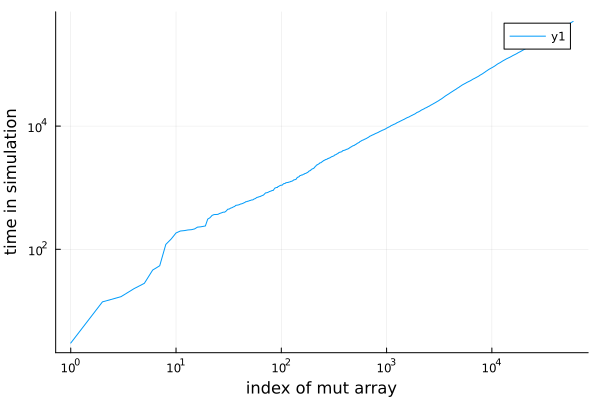

In [157]:
plot(data[:,4], xlabel= "index of mut array", 
    ylabel="time in simulation", xscale =:log10, yscale =:log10)

In [44]:
start_t = 10000
n_muts = 5000
lag = 3
window = 5000
each_step = start_t:lag:(start_t-1)+(lag*n_muts)
println(length(each_step))
println(each_step)


@time y = cont_entr_setofmuts_eachstep(h, J, matrices, mut_times, 
    mut_sites, data[:,2], data[:,3], window, each_step)
;

5000
10000:3:24997
 48.791087 seconds (176.84 M allocations: 27.539 GiB, 10.81% gc time, 0.55% compilation time)


In [154]:
start_t = 10000
n_muts = 5000
lag = 3
window = 50
each_step = start_t:lag:(start_t-1)+(lag*n_muts)

10000:3:24997

In [99]:
scatter(data[:,5], data[:,6], label = "CDE_nat")
scatter!(data[:,5], data[:,8] , label = "CIE")
savefig("../only_amino.png")

"/home/disat/ldibari/Gen.jl/only_amino.png"

In [155]:
scatter(data[each_step,5], data[each_step,6], label = "CDE_nat")
scatter!(data[each_step,5], data[each_step,8], label = "CIE")
savefig("../nucl.png")

"/home/disat/ldibari/Gen.jl/nucl.png"

In [156]:
cie_mut[mut_sites[100]]

3.7276192577927043

In [159]:
matrices[1000000]

16

In [127]:
cde_mut = []
cie_mut = []
for i in 1:length(mut_sites)
    push!(cie_mut, entr_nat[mut_sites[i]] / log(2))
    push!(cde_mut, cde_1site(mut_sites[i], matrices[mut_times[i],:], h, J, q = 21)[1] / log(2))
end
    

In [129]:
scatter(cde_mut, cie_mut)
savefig("../corr.png")

"/home/disat/ldibari/Gen.jl/corr.png"

In [119]:
cde_1site(14, matrices[24,:], h, J, q=21)

1-element Vector{Float64}:
 1.2692176681248923

In [45]:
mut_data = data[each_step,:]
using CSV
CSV.write("../data/figures/suppl_data_fig3/cont_entr_df.csv", mut_data)
;

LoadError: SystemError: opening file "../suppl_data_fig3/cont_entr_df.csv": No such file or directory

In [46]:
x = 2:window-49
cont = y[:, 50:window-1]
entren = y[:, window+2:end-50]
;

In [20]:
@time writedlm("../data/figures/suppl_data_fig3/cont", cont)

 44.943776 seconds (49.54 M allocations: 10.338 GiB, 4.89% gc time, 0.43% compilation time)


In [21]:
@time writedlm("../data/figures/suppl_data_fig3/entren", entren)

 21.898244 seconds (49.51 M allocations: 10.337 GiB, 9.57% gc time)


In [ ]:
@time writedlm("../data/figures/suppl_data_fig3/x_steps", x)